# Regularization Testing

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.utils import plot_model
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate, Reshape, LSTM, CuDNNLSTM
#from keras.layers import K
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [2]:
class1 = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
class2 = {0:'Mononuclear',1:'Polynuclear'}
tree_path = 'C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\BCCD\\Annotations'
image_path = 'C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\BCCD\\JPEGImages'

## Define Helper functions and Load Data

In [3]:
def get_data(folder, size):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=size)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [19]:
size=(64, 64)
X_train, y_train, z_train = get_data('C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\dataset2-master\\images\\TRAIN\\', size)
X_test, y_test, z_test = get_data('C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\dataset2-master\\images\\TEST\\', size)

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:01<00:00, 389.27it/s]


In [20]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

# Normalize to [0,1]
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

# Dropout

In [10]:
#Training Parameters 
batch_size  = 128
epochs      = 100

#Input Data parameters
num_classes = 5
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 3)

#Build Model
model = Sequential() #Keras sequential builder
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(num_classes, activation='softmax'))

#Train Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [11]:
history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Epoch 1/100
 - 9s - loss: 1.5961 - acc: 0.2549 - val_loss: 1.3841 - val_acc: 0.2626
Epoch 2/100
 - 8s - loss: 1.3955 - acc: 0.2717 - val_loss: 1.3744 - val_acc: 0.2847
Epoch 3/100
 - 8s - loss: 1.3835 - acc: 0.2915 - val_loss: 1.3887 - val_acc: 0.2505
Epoch 4/100
 - 8s - loss: 1.3672 - acc: 0.3103 - val_loss: 1.3087 - val_acc: 0.3563
Epoch 5/100
 - 8s - loss: 1.3110 - acc: 0.3665 - val_loss: 1.2648 - val_acc: 0.3534
Epoch 6/100
 - 8s - loss: 1.2771 - acc: 0.3893 - val_loss: 1.1769 - val_acc: 0.4503
Epoch 7/100
 - 8s - loss: 1.2487 - acc: 0.4118 - val_loss: 1.2119 - val_acc: 0.4017
Epoch 8/100
 - 8s - loss: 1.2354 - acc: 0.4140 - val_loss: 1.1374 - val_acc: 0.4499
Epoch 9/100
 - 8s - loss: 1.2109 - acc: 0.4343 - val_loss: 1.1038 - val_acc: 0.4821
Epoch 10/100
 - 8s - loss: 1.1868 - acc: 0.4520 - val_loss: 1.0846 - val_acc: 0.4745
Epoch 11/100
 - 8s - loss: 1.1628 - acc: 0.4650 - val_loss: 1.0903 - val_acc: 0.4813
Epoch 12/100
 - 8s - loss: 1.1627 - acc: 0.4648 - val_loss: 1.0511 - val_a

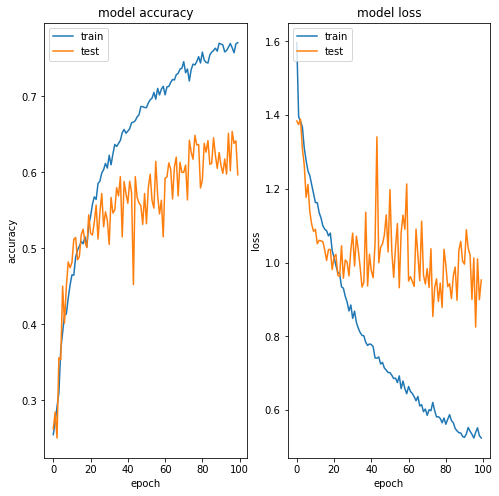

In [12]:
plot_learning_curve(history.history)
plt.show()

# Batch Normalization

In [28]:
#Training Parameters 
batch_size  = 128
epochs      = 200

#Input Data parameters
num_classes = 5
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 3)

#Build Model
model = Sequential() #Keras sequential builder
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(momentum=.5, scale=True))
#model.add(Dropout(.1))
model.add(Dense(num_classes, activation='softmax'))

#Train Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [29]:
history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Epoch 1/100
 - 10s - loss: 1.6831 - acc: 0.3710 - val_loss: 1.6130 - val_acc: 0.3949
Epoch 2/100
 - 9s - loss: 1.0428 - acc: 0.5295 - val_loss: 1.7087 - val_acc: 0.3804
Epoch 3/100
 - 8s - loss: 0.8925 - acc: 0.6084 - val_loss: 1.8476 - val_acc: 0.4922
Epoch 4/100
 - 8s - loss: 0.7844 - acc: 0.6596 - val_loss: 1.3016 - val_acc: 0.4479
Epoch 5/100
 - 8s - loss: 0.6907 - acc: 0.7023 - val_loss: 1.0788 - val_acc: 0.5661
Epoch 6/100
 - 8s - loss: 0.6216 - acc: 0.7366 - val_loss: 2.4904 - val_acc: 0.4885
Epoch 7/100
 - 8s - loss: 0.5677 - acc: 0.7579 - val_loss: 1.2431 - val_acc: 0.5376
Epoch 8/100
 - 8s - loss: 0.5173 - acc: 0.7767 - val_loss: 1.3835 - val_acc: 0.5191
Epoch 9/100
 - 8s - loss: 0.4788 - acc: 0.7975 - val_loss: 1.9648 - val_acc: 0.4142
Epoch 10/100
 - 8s - loss: 0.4710 - acc: 0.7997 - val_loss: 2.0361 - val_acc: 0.5195
Epoch 11/100
 - 8s - loss: 0.4314 - acc: 0.8191 - val_loss: 1.4739 - val_acc: 0.5424
Epoch 12/100
 - 8s - loss: 0.4108 - acc: 0.8285 - val_loss: 1.3490 - val_

KeyboardInterrupt: 

In [ ]:
plot_learning_curve(history.history)
plt.show()

# Feature Centering

In [24]:
#Training Parameters 
batch_size  = 128
epochs      = 200

#Input Data parameters
num_classes = 5
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 3)

#Build Model
model = Sequential() #Keras sequential builder
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(num_classes, activation='softmax'))

#Train Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=.01), metrics=['accuracy'])

datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [25]:
history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [datagen.standardize(X_test), y_testHot], verbose=2)

Epoch 1/200
 - 9s - loss: 11.9769 - acc: 0.2478 - val_loss: 12.0999 - val_acc: 0.2493
Epoch 2/200
 - 9s - loss: 12.0975 - acc: 0.2494 - val_loss: 12.0999 - val_acc: 0.2493
Epoch 3/200
 - 9s - loss: 12.0992 - acc: 0.2493 - val_loss: 12.0999 - val_acc: 0.2493
Epoch 4/200
 - 9s - loss: 12.0966 - acc: 0.2495 - val_loss: 12.0999 - val_acc: 0.2493
Epoch 5/200
 - 9s - loss: 12.0975 - acc: 0.2494 - val_loss: 12.0999 - val_acc: 0.2493
Epoch 6/200
 - 9s - loss: 12.1005 - acc: 0.2493 - val_loss: 12.0999 - val_acc: 0.2493
Epoch 7/200
 - 9s - loss: 12.1018 - acc: 0.2492 - val_loss: 12.0999 - val_acc: 0.2493
Epoch 8/200
 - 9s - loss: 12.0975 - acc: 0.2494 - val_loss: 12.0999 - val_acc: 0.2493
Epoch 9/200
 - 9s - loss: 12.0949 - acc: 0.2496 - val_loss: 12.0999 - val_acc: 0.2493
Epoch 10/200


KeyboardInterrupt: 

In [ ]:
plot_learning_curve(history.history)
plt.show()